In [1]:
import sys
import subprocess
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seismic-library/')
import kaggle_support as kgs
import importlib
import time
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import cupy as cp
import copy
import seis_forward2

In [2]:
data = kgs.load_all_train_data(validation_only=True) + kgs.load_all_test_data()
data = data

In [3]:
folder = kgs.cache_dir_read + '/model_TV2D_refine/'
#files_default = glob.glob(folder + '/*')
#files_default = ([os.path.basename(f) for f in files_default])
#files_default = set(files_default)
files_todo = ([os.path.basename(f) for f in glob.glob(folder + '/*')])
files_todo = set(files_todo)

In [4]:
def get_data_from_file(f):
    data = kgs.dill_load(f)[0]
    return data
res = dict()
res['cache_name'], res['is_train'], res['update_mae'], res['score_brendan'], res['score'], res['seis_err_rms'], res['seis_err_rms_brendan'] = [],[],[],[],[],[],[]
for d in tqdm(data):
    f = d.cache_name()
    if f in files_todo:
        vel_default = get_data_from_file(folder +f)
        vel_brendan = get_data_from_file(kgs.cache_dir_read + '/brendan/' +f)
        res['cache_name'].append(f)
        res['is_train'].append(d.is_train)
        res['update_mae'].append(np.mean(np.abs(vel_default.data-vel_brendan.data)))
        if d.is_train:
            d.velocity.load_to_memory()
            res['score'].append(np.mean(np.abs(vel_default.data-cp.asnumpy(d.velocity.data))))
            res['score_brendan'].append(np.mean(np.abs(vel_brendan.data-cp.asnumpy(d.velocity.data))))
            d.velocity.unload()
        else:
            res['score'].append(np.nan)
            res['score_brendan'].append(np.nan)
            
        vel = copy.deepcopy(vel_default)
        vel.to_cupy()
        vel.data = vel.data.astype(cp.float64)
        vel.min_vel = vel.min_vel.astype(cp.float64)
        seis = kgs.Seismogram()
        seis.from_vector(seis_forward2.vel_to_seis(vel.to_vector())[0])
        d.seismogram.load_to_memory()
        res['seis_err_rms'].append(kgs.rms(seis.to_vector() - d.seismogram.to_vector()).get())

        vel = copy.deepcopy(vel_brendan)
        vel.to_cupy()
        vel.data = vel.data.astype(cp.float64)
        vel.min_vel = vel.min_vel.astype(cp.float64)
        seis = kgs.Seismogram()
        seis.from_vector(seis_forward2.vel_to_seis(vel.to_vector())[0])
        d.seismogram.load_to_memory()
        res['seis_err_rms_brendan'].append(kgs.rms(seis.to_vector() - d.seismogram.to_vector()).get())
        
        d.seismogram.unload()
df = pd.DataFrame(res)
tr = df['is_train']
ntr = np.logical_not(df['is_train'])

  0%|                                                                                        | 0/70818 [00:00<?, ?it/s]

capturing graph


100%|███████████████████████████████████████████████████████████████████████████| 70818/70818 [09:17<00:00, 127.11it/s]


In [5]:
np.sum(df['is_train']), np.sum(np.logical_not(df['is_train']))

(997, 3396)

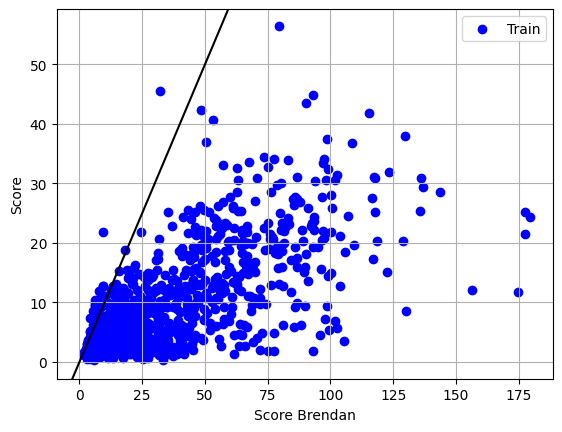

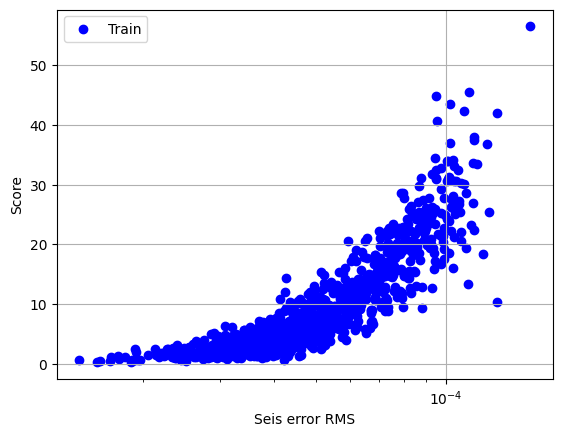

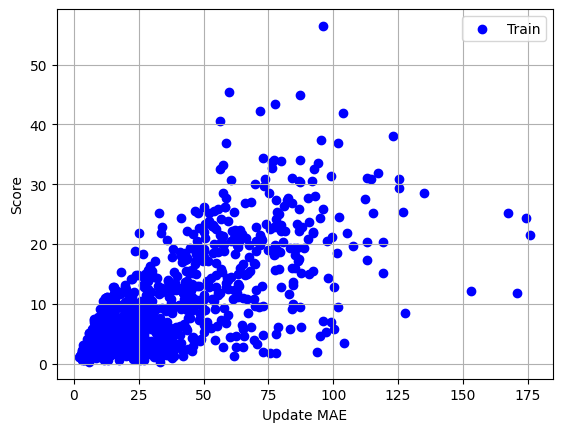

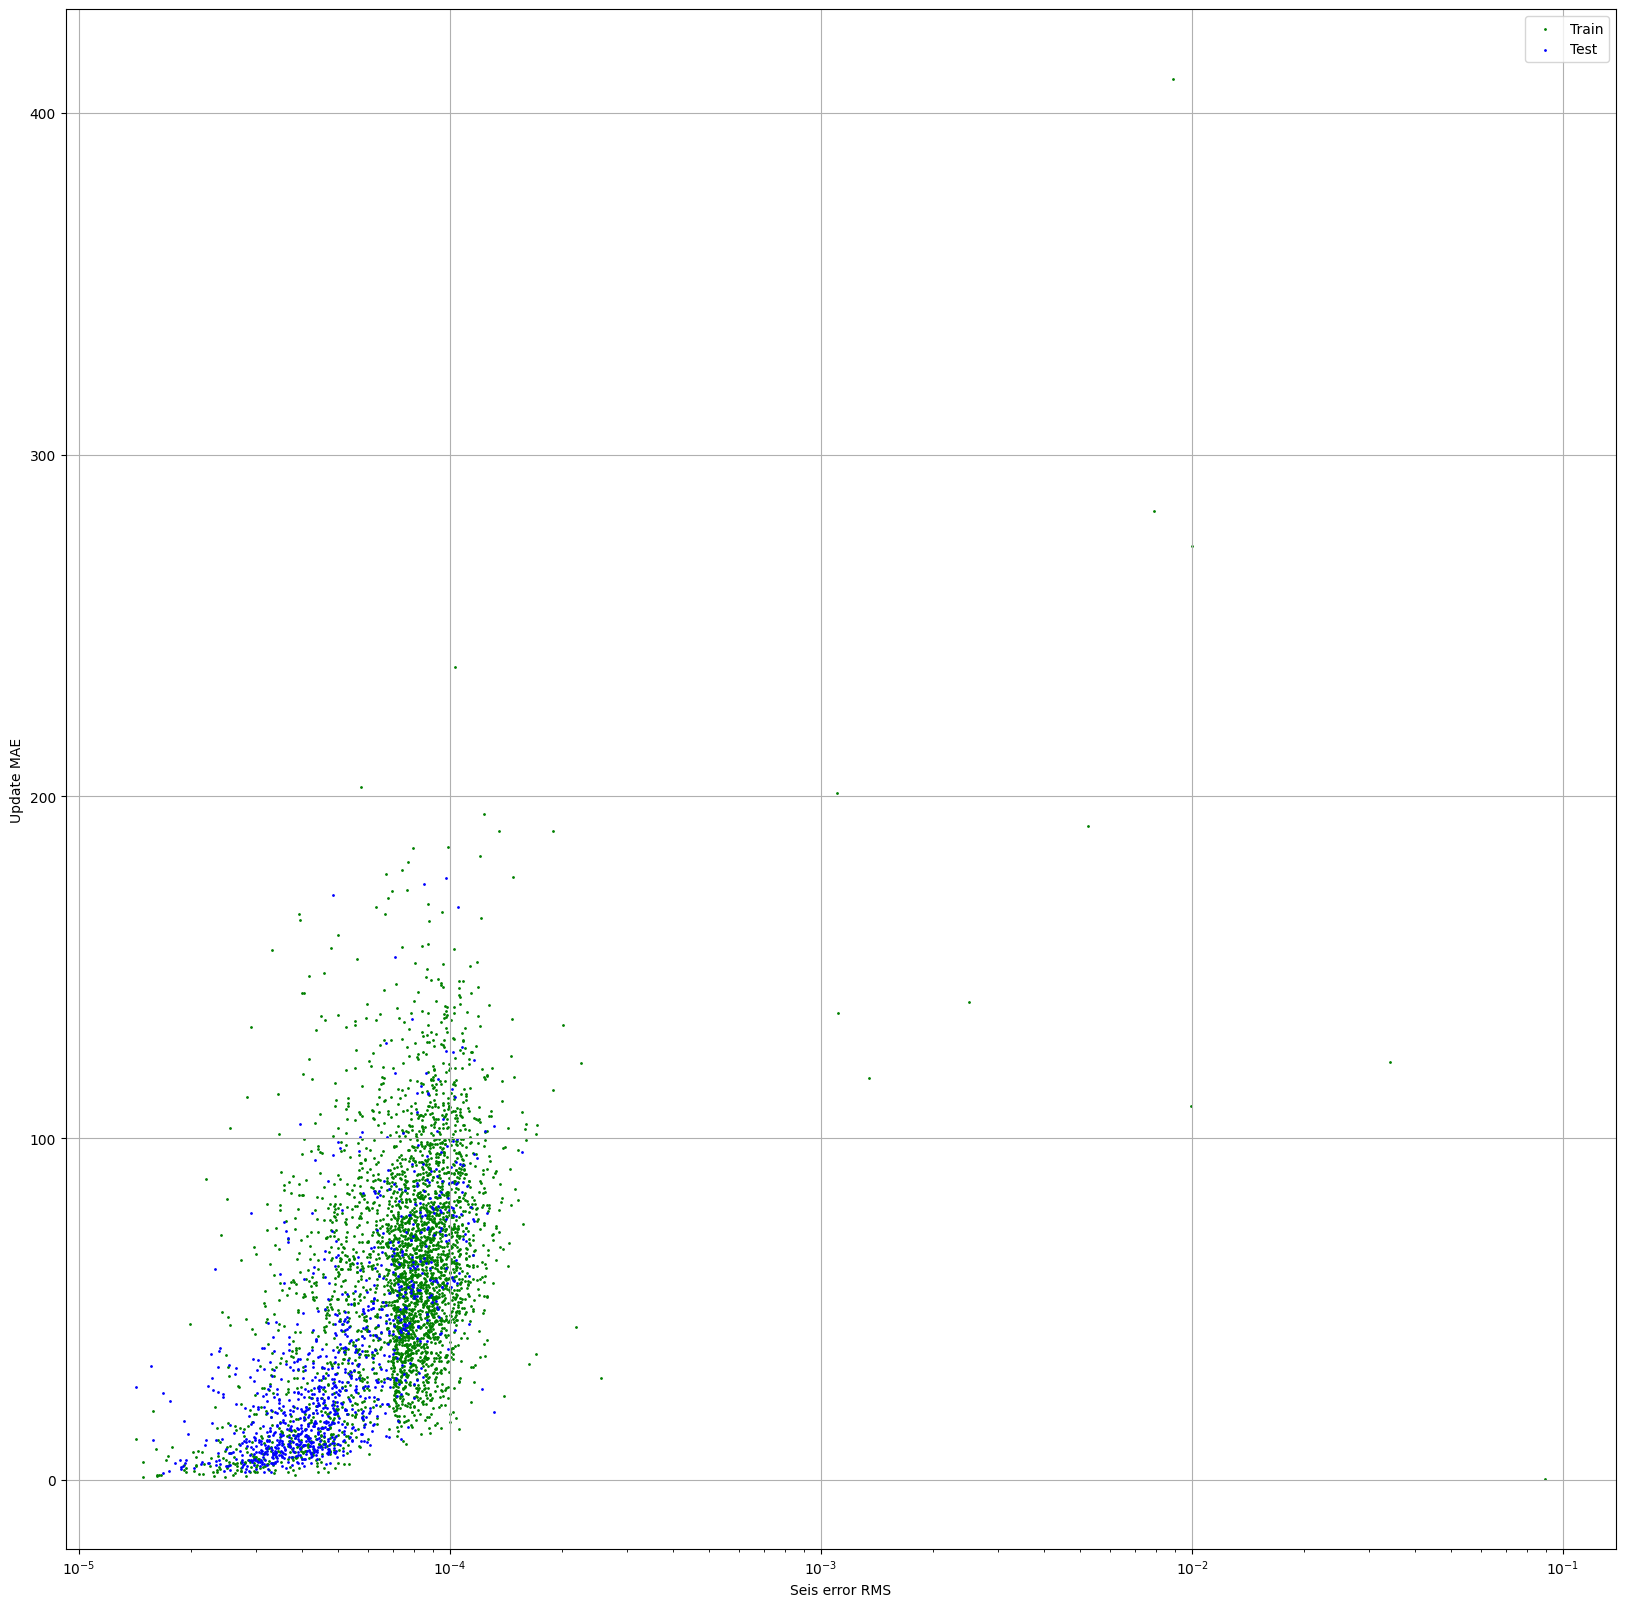

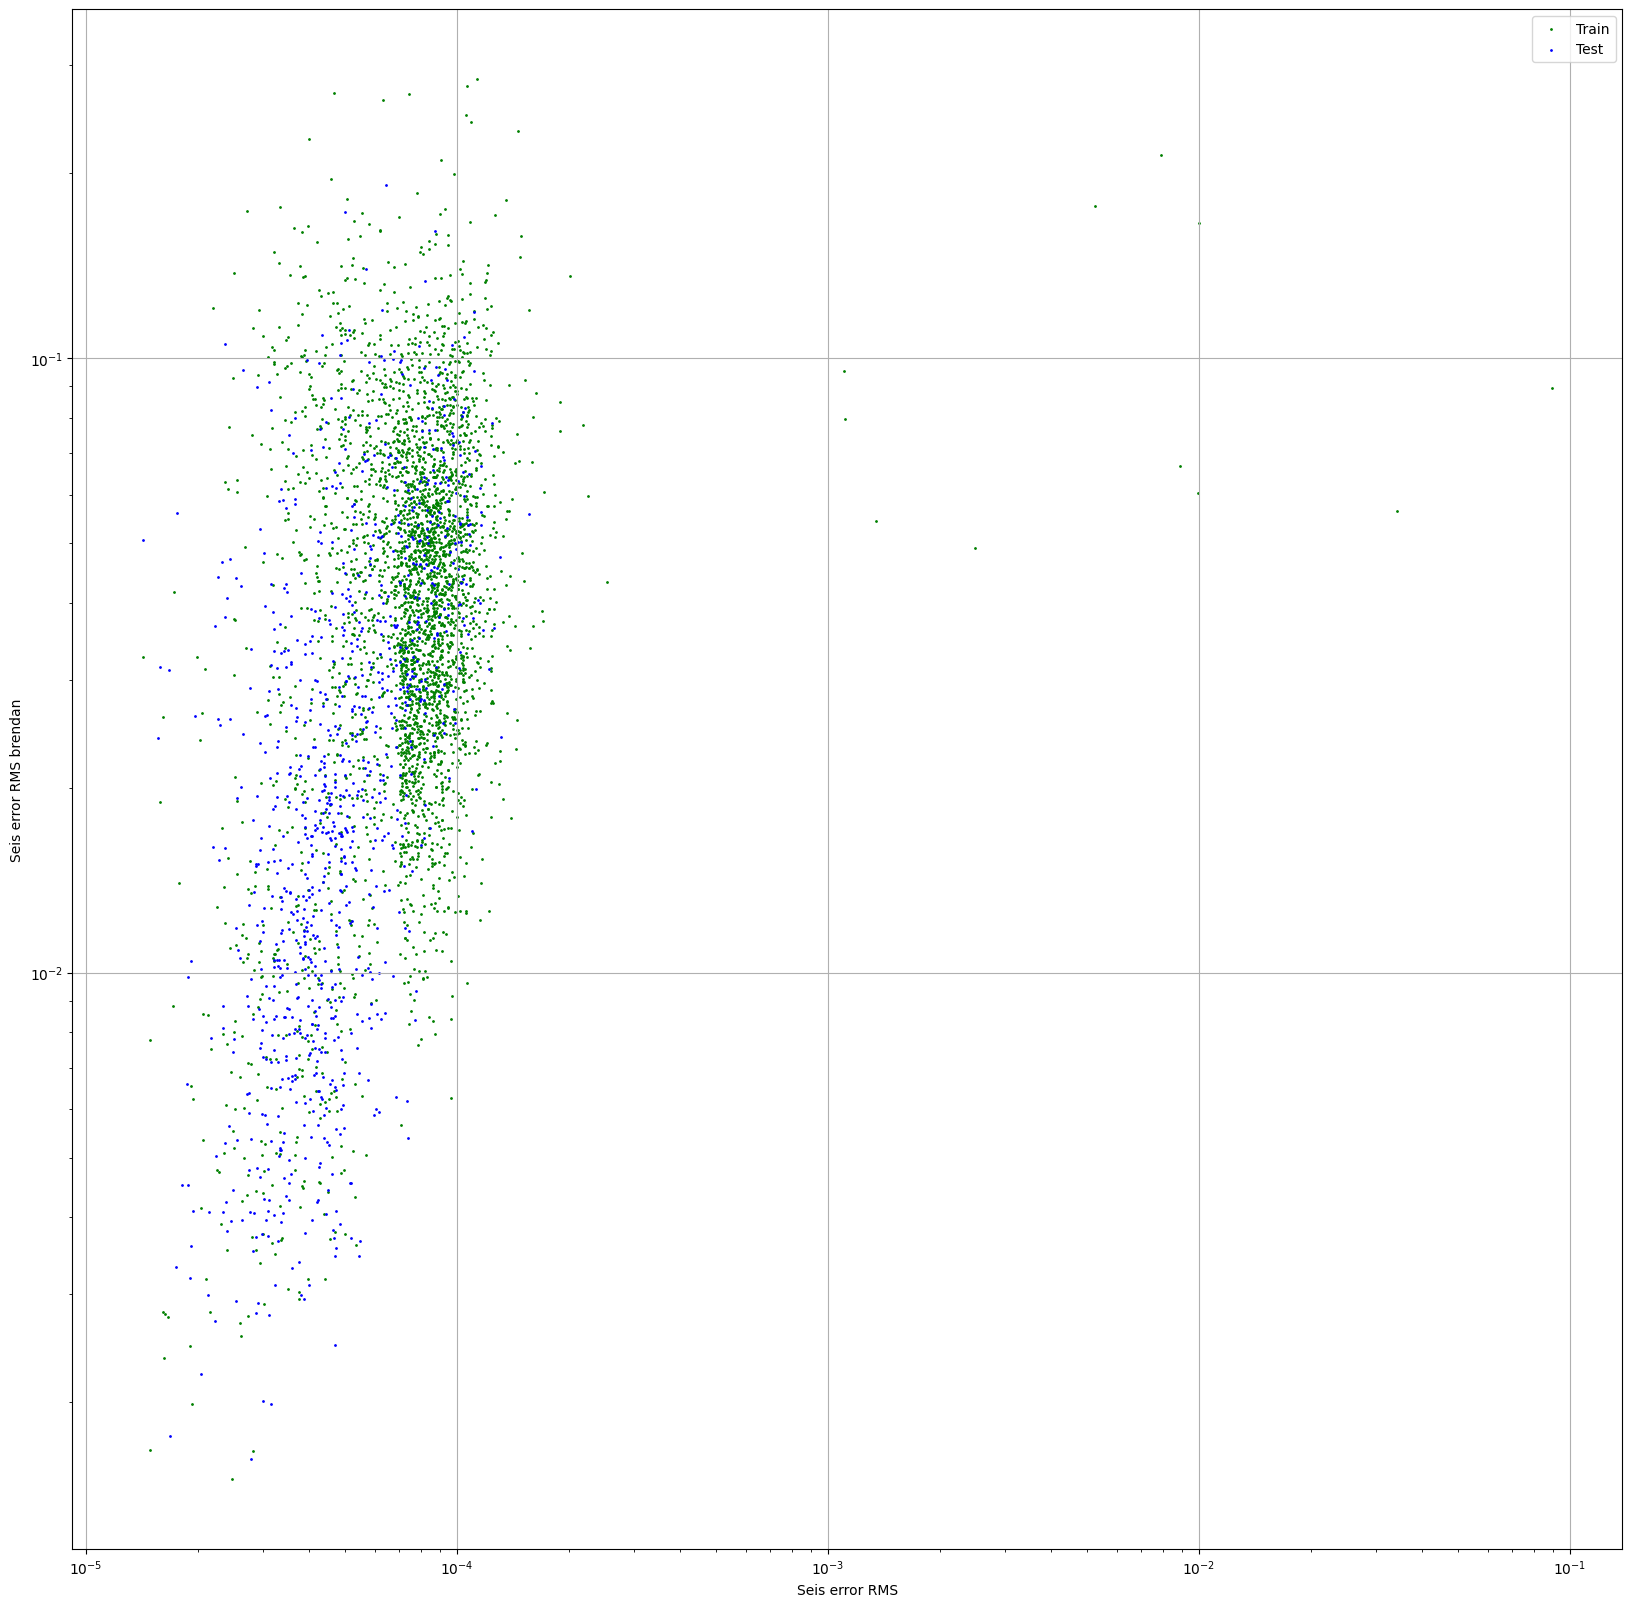

In [6]:
plt.figure();plt.scatter(df[tr]['score_brendan'],df[tr]['score'],color='blue');plt.xlabel('Score Brendan');plt.ylabel('Score');plt.legend(('Train',));plt.grid(True);plt.axline((1e-3,1e-3),(1e-2,1e-2),color='black')
plt.figure();plt.scatter(df[tr]['seis_err_rms'],df[tr]['score'],color='blue');plt.xlabel('Seis error RMS');plt.ylabel('Score');plt.legend(('Train',));plt.grid(True);plt.xscale('log');
plt.figure();plt.scatter(df[tr]['update_mae'],df[tr]['score'],color='blue');plt.xlabel('Update MAE');plt.ylabel('Score');plt.legend(('Train',));plt.grid(True);

plt.figure(figsize=(20,20));plt.scatter(df[ntr]['seis_err_rms'],df[ntr]['update_mae'],1,color='green');plt.scatter(df[tr]['seis_err_rms'],df[tr]['update_mae'],1,color='blue');
plt.xlabel('Seis error RMS');plt.ylabel('Update MAE');plt.legend(('Train','Test'));plt.grid(True);plt.xscale('log');

plt.figure(figsize=(20,20));plt.scatter(df[ntr]['seis_err_rms'],df[ntr]['seis_err_rms_brendan'],1,color='green');plt.scatter(df[tr]['seis_err_rms'],df[tr]['seis_err_rms_brendan'],1,color='blue');
plt.xlabel('Seis error RMS');plt.ylabel('Seis error RMS brendan');plt.legend(('Train','Test'));plt.grid(True);plt.xscale('log');plt.yscale('log');
#plt.axline((1e-3,1e-3),(1e-2,1e-2),color='black')

(array(0.00015651), array(0.08948991))

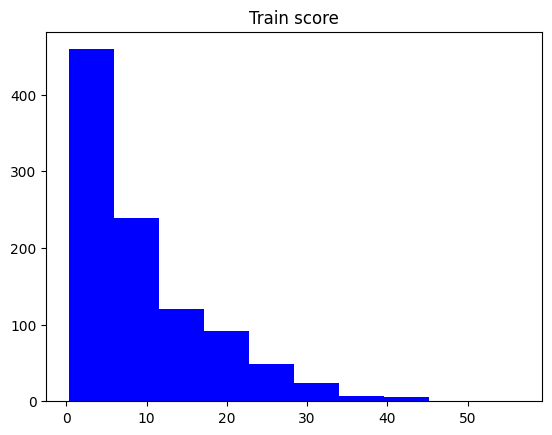

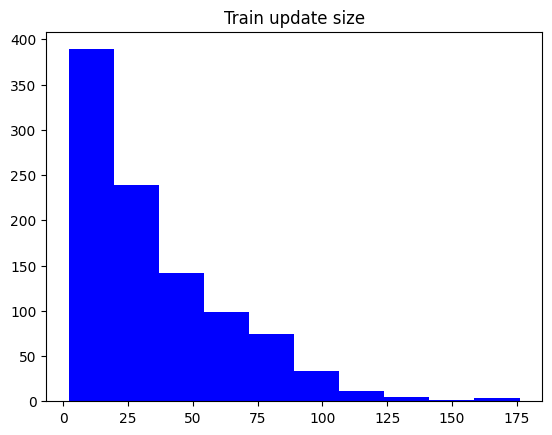

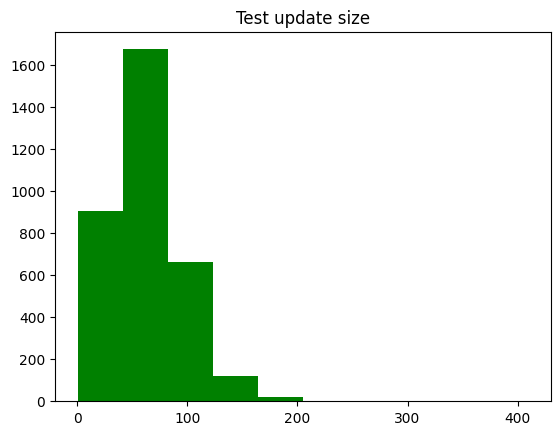

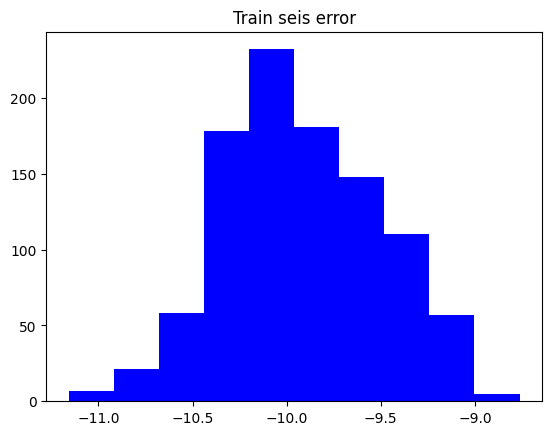

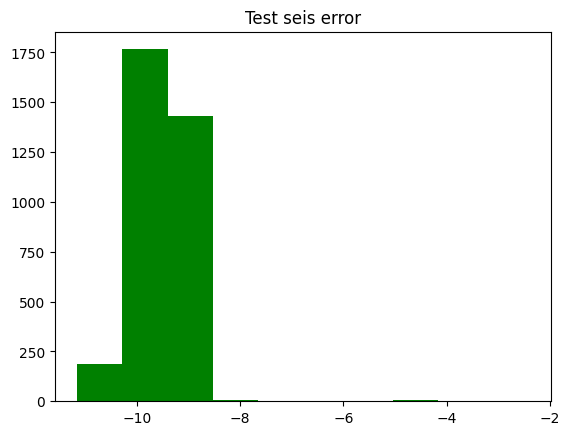

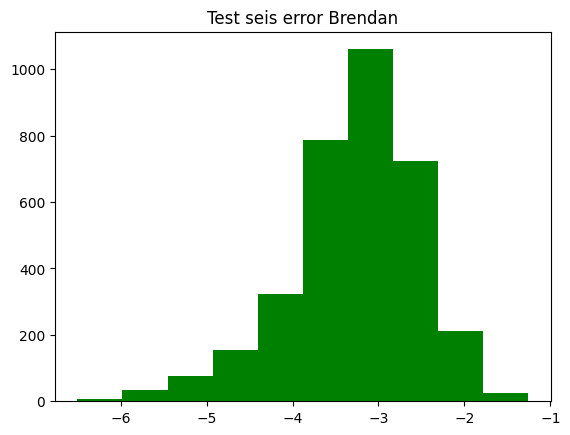

In [7]:
plt.figure();plt.hist(df[df['is_train']]['score'], color='blue');plt.title('Train score')
plt.figure();plt.hist(df[df['is_train']]['update_mae'], color='blue');plt.title('Train update size')
plt.figure();plt.hist(df[np.logical_not(df['is_train'])]['update_mae'], color='green');plt.title('Test update size')
plt.figure();plt.hist(np.log(np.array(list(df[df['is_train']]['seis_err_rms'].to_numpy()))), color='blue');plt.title('Train seis error')
plt.figure();plt.hist(np.log(np.array(list(df[ntr]['seis_err_rms'].to_numpy()))), color='green');plt.title('Test seis error')
plt.figure();plt.hist(np.log(np.array(list(df[ntr]['seis_err_rms_brendan'].to_numpy()))), color='green');plt.title('Test seis error Brendan')
np.max(df[tr]['seis_err_rms']), np.max(df[ntr]['seis_err_rms'])

In [8]:
# for _,row in df.iterrows():
#     if row['seis_err_rms']>2e-4:
#         for d in data:
#             if d.cache_name() == row['cache_name']:
#                 #print(d.cache_name());
#                 #if not 'Style_A' in d.family:
#                 #print(row)
#                 f=d.cache_name()
#                 vel_default = get_data_from_file(folder +f)
#                 vel_brendan = get_data_from_file(kgs.cache_dir_read + '/brendan/' +f)
#                 _,ax = plt.subplots(1,3,figsize=(18,6))
#                 plt.sca(ax[0]);plt.imshow(vel_brendan.data);plt.title('NN prediction');plt.colorbar()
#                 plt.sca(ax[2]);plt.imshow(vel_default.data);plt.title('Final prediction');plt.colorbar()
#                 plt.sca(ax[1]);plt.imshow(vel_default.data-vel_brendan.data);plt.title('Update');plt.colorbar()
#                 print(np.mean(np.abs(vel_default.data-vel_brendan.data)))
#                 plt.suptitle(f + ', ' + str(row['score']))
#                 plt.pause(0.001)
#     if (row['is_train'] and row['score']>0.5):
#         for d in data:
#             if d.cache_name() == row['cache_name']:
#                 #print(d.cache_name());
#                 #if not 'Style_A' in d.family:
#                 #print(row)
#                 d.load_to_memory()
#                 vel_correct = d.velocity
#                 vel_correct.data = vel_correct.data.get()
#                 f=d.cache_name()
#                 vel_default = get_data_from_file(folder +f)
#                 vel_brendan = get_data_from_file(kgs.cache_dir_read + '/brendan/' +f)
#                 _,ax = plt.subplots(1,3,figsize=(18,6))
#                 plt.sca(ax[0]);plt.imshow(vel_default.data);plt.title('Final prediction');plt.colorbar()
#                 plt.sca(ax[1]);plt.imshow(vel_correct.data);plt.title('Correct');plt.colorbar()
#                 plt.sca(ax[2]);plt.imshow(vel_default.data-vel_correct.data);plt.title('Error');plt.colorbar()
#                 print(np.mean(np.abs(vel_default.data-vel_brendan.data)))
#                 plt.suptitle(f + ', ' + str(row['score']))
#                 plt.pause(0.001)

In [9]:
400*50/65000

0.3076923076923077

In [10]:
df2 = df[tr].sort_values('seis_err_rms', ascending=False)
df2

,cache_name,is_train,update_mae,score_brendan,score,seis_err_rms,seis_err_rms_brendan
522,data1__CurveVel_B__48,True,95.966601,79.429517,56.475660,0.00015650518771747975,0.05570796300335284
864,seis6_1_0__FlatFault_B__234,True,19.895627,22.616380,10.374837,0.00013138456021713675,0.024214401419814364
91,seis6_1_0__CurveFault_B__182,True,103.636217,115.312486,41.918069,0.0001309535845846532,0.04751025288904235
675,data1__CurveVel_B__356,True,78.184675,62.979651,25.383322,0.00012587000157339472,0.0364193060257135
222,seis6_1_0__CurveFault_B__444,True,102.053318,108.633435,36.876574,0.00012445454558039783,0.07845120561322129
...,...,...,...,...,...,...,...
426,data1__CurveVel_A__356,True,2.163164,1.924210,1.182939,1.682360309789584e-05,0.001760883196004224
514,data1__CurveVel_B__32,True,25.332529,25.178906,0.547550,1.6783614538207836e-05,0.03104016222604935
611,data1__CurveVel_B__228,True,11.743923,11.436724,0.596577,1.5864380064889553e-05,0.03138771878924434
523,data1__CurveVel_B__50,True,33.279155,33.185964,0.367491,1.566937312972928e-05,0.024131509662899692
